In [21]:
import os, sys
import numpy as np
import uproot
import awkward as ak
import pandas as pd
from time import time

import pickle
import json

from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings("ignore")

In order to use the scripts in utils, add the path to your working directory to PYTHONPATH.

In [22]:
sys.path.append('/home/rusack/vadna042/HGCALDRNElectron') # change this path to your own directory
from utils.pltutils import plt

In [23]:
# set custom functions
plt.rcParams['axes.linewidth'] = 1.4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.minor.size'] = 2.5
plt.rcParams['xtick.minor.size'] = 4.0
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.labelsize'] = 'large'
plt.rcParams['xtick.labelsize'] = 'large'

In [24]:
def GausPDF(x, *c):
    
    A = c[0] # fraction of crystalball
    
    #define function parameters
    mu = c[1]
    sigma = c[2]
    z = (x-mu)/sigma
    G = A*(1/np.sqrt(2*(sigma**2)*np.pi))*np.exp(-(z**2)/2)
    return G

In [25]:
def Pol1PDF(x, *c):
    m = c[0]
    c = c[1]
    return m*x+c

In [26]:
# def fit_gaussian(x):
#     # start with inital guesses
#     _mu = np.mean(x)
#     _sigma = np.std(x)
#     _A = np.sum(x)/np.sqrt(2*np.pi*_sigma)
    
#     return minimize(sum_chi2_gaussian, (_A, _mu, _sigma))

In [27]:
casinfo = pd.read_csv('/home/rusack/vadna042/HGCALDRNElectron/utils/cassette_info.txt',delimiter='\t')

In [28]:
folders_data = ['/home/rusack/shared/pickles/hgcal_electron/data_h3_selection/100',
'/home/rusack/shared/pickles/hgcal_electron/data_h3_selection/150',
'/home/rusack/shared/pickles/hgcal_electron/data_h3_selection/200',
'/home/rusack/shared/pickles/hgcal_electron/data_h3_selection/250',
'/home/rusack/shared/pickles/hgcal_electron/data_h3_selection/30',
'/home/rusack/shared/pickles/hgcal_electron/data_h3_selection/300',
'/home/rusack/shared/pickles/hgcal_electron/data_h3_selection/50',
'/home/rusack/shared/pickles/hgcal_electron/data_h3_selection/80',
'/home/rusack/shared/pickles/hgcal_electron/data_h3_selection/20']

In [29]:
folders_mc = ['/home/rusack/shared/pickles/hgcal_electron/mc_h3_selection/100',
'/home/rusack/shared/pickles/hgcal_electron/mc_h3_selection/120',
'/home/rusack/shared/pickles/hgcal_electron/mc_h3_selection/150',
'/home/rusack/shared/pickles/hgcal_electron/mc_h3_selection/20',
'/home/rusack/shared/pickles/hgcal_electron/mc_h3_selection/200',
'/home/rusack/shared/pickles/hgcal_electron/mc_h3_selection/250',
'/home/rusack/shared/pickles/hgcal_electron/mc_h3_selection/30',
'/home/rusack/shared/pickles/hgcal_electron/mc_h3_selection/300',
'/home/rusack/shared/pickles/hgcal_electron/mc_h3_selection/50',
'/home/rusack/shared/pickles/hgcal_electron/mc_h3_selection/80']

In [30]:
folders = {'data': folders_data, 'mc': folders_mc}

In [31]:
path_to_output_data = '/home/rusack/shared/pickles/hgcal_electron/data_combined_h3_selection/'
path_to_output_mc = '/home/rusack/shared/pickles/hgcal_electron/mc_combined_h3_selection/'
pickles = ['rechit_x', 'rechit_y', 'rechit_z', 'rechit_energy']

In [32]:
target_array = {'data': {}, 'mc': {}}
prediction_array = {'data': {}, 'mc': {}}
arrays = {'data': {}, 'mc': {}}

In [33]:
arrays = {'data': {}, 'mc': {}}
for f in folders_data:
    e = f.split('/')[-1]
    arrays['data'][int(e)] = {}
    for ip, p in enumerate(pickles):
        filename = '{}/{}.pickle'.format(f, p)
        with open(filename, 'rb') as file_:
            arrays['data'][int(e)][p] = pickle.load(file_)

for f in folders_mc:
    e = f.split('/')[-1]
    arrays['mc'][int(e)] = {}
    for ip, p in enumerate(pickles):
        filename = '{}/{}.pickle'.format(f, p)
        with open(filename, 'rb') as file_:
            arrays['mc'][int(e)][p] = pickle.load(file_)

In [34]:
for dtype in ['data','mc']:
    for f in folders[dtype]:
        e = f.split('/')[-1]
        target_file = '/home/rusack/shared/pickles/hgcal_electron/{}_h3_selection/{}/all_target.pickle'.format(dtype, e)
        prediction_file = '/home/rusack/joshib/EM-ID-and-reco/training_folders/hgcal_electron_flat_0001_softplus_agg2_mare_loss_v2_iteration2/pred_{}_h3_selection_{}.pickle'.format(dtype, e)

        with open(target_file, 'rb') as file0:
            target_array[dtype][int(e)] = np.array(pickle.load(file0))
        #with open(prediction_file, 'rb') as file0:
        #    prediction_array[dtype][int(e)] = np.array(pickle.load(file0))

In [35]:
fit_parameters = {'data': {}, 'mc': {}}

In [36]:
def fit_gaussian_mip(earray, ax, dtype, energy):
    
    print('plotting energy = {} GeV in {}, {}'.format(e, irow, jcol))
    mean_ = np.mean(earray)
    std_ = np.std(earray)
    
    # plot data
    data_range = (mean_-2e3, mean_+2e3)
    M = np.linspace(data_range[0], data_range[1], 100)
   
    data_hist2_array = ax.hist(earray,
             histtype='step', color='w', linewidth=0,
             range=data_range, bins=50)

    xarray = (data_hist2_array[1][1:]+data_hist2_array[1][:-1])/2
    yarray = data_hist2_array[0]

    ax.scatter(xarray, yarray, marker='o', c='black', s=40)
    ax.bar(xarray, yarray, width=0.05, color='none', yerr=np.sqrt(yarray))

    results = curve_fit(GausPDF, xarray, yarray, 
                    p0=(max(yarray), mean_, std_))
#                    bounds=((0,0,0),(1e2*max(yarray),1e6,1e6)))
    E = yarray-np.array([ GausPDF(m, *results[0]) for m in xarray])
    E = E/(np.sqrt(yarray+0.001))
    chi2 = np.sqrt(sum(E**2)/(len(E)-1))

    ax.plot(M, [ GausPDF(m, *results[0]) for m in M], linestyle='dashed')

    # plot data
    ax.set_xlim(data_range)
    ax.set_ylabel('Events (noamlized)', size=14)
    ax.set_xlabel('Measured Energy (MIP)', size=14)
    stat_text = '''
    A = {:0.2f}
    $\mu$ = {:0.2f}
    $\sigma$ = {:0.2f}
    $\chi^2$ = {:0.2f}
    '''.format(results[0][0], results[0][1], abs(results[0][2]), chi2)
    stat_text_box = ax.text(x=data_range[0]+0.05e3, y=0.7*max(yarray),
        s=stat_text,
        fontsize=12,
        fontfamily='sans-serif',
        horizontalalignment='left', 
        verticalalignment='bottom')
    ax.set_title('E = {} GeV'.format(energy))
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    return results[0]

In [37]:
def fit_gaussian(earray, ax, dtype, energy):
    
    print('plotting energy = {} GeV in {}, {}'.format(e, irow, jcol))
    mean_ = np.mean(earray)
    std_ = np.std(earray)
    
    # plot data
    data_range = (mean_-20, mean_+20)
    M = np.linspace(data_range[0], data_range[1], 100)
   
    data_hist2_array = ax.hist(earray,
             histtype='step', color='w', linewidth=0,
             range=data_range, bins=50)

    xarray = (data_hist2_array[1][1:]+data_hist2_array[1][:-1])/2
    yarray = data_hist2_array[0]
    temptemp = [xarray,yarray]
    np.savetxt(f"/home/rusack/vadna042/{e}.csv", np.transpose(temptemp), delimiter=",")

    ax.scatter(xarray, yarray, marker='o', c='black', s=40)
    ax.bar(xarray, yarray, width=0.05, color='none', yerr=np.sqrt(yarray))

    results = curve_fit(GausPDF, xarray, yarray, 
                    p0=(max(yarray), mean_, std_),
                    bounds=((0,0,0),(1e2*max(yarray),1e3,1e3)))
    E = yarray-np.array([ GausPDF(m, *results[0]) for m in xarray])
    E = E/(np.sqrt(yarray+0.001))
    chi2 = np.sqrt(sum(E**2)/(len(E)-1))

    ax.plot(M, [ GausPDF(m, *results[0]) for m in M], linestyle='dashed')

    # plot data
    ax.set_xlim(data_range)
    ax.set_ylabel('Events (noamlized)', size=14)
    ax.set_xlabel('Measured Energy (GeV)', size=14)
    stat_text = '''
    A = {:0.2f}
    $\mu$ = {:0.2f}
    $\sigma$ = {:0.2f}
    $\chi^2$ = {:0.2f}
    '''.format(results[0][0], results[0][1], results[0][2], chi2)
    stat_text_box = ax.text(x=mean_+5, y=0.7*max(yarray),
        s=stat_text,
        fontsize=12,
        fontfamily='sans-serif',
        horizontalalignment='left', 
        verticalalignment='bottom')
    ax.set_title('E = {} GeV'.format(energy))
    return results[0]

Next, produce the rough estimate of the sum of rechit energies. This is done by multiplying a factor of 0.01 as 1 MIP roughly corresponds to 10 MeV. Then, the gaussian is fitted using scipy's curve_fit function.

<Figure size 432x288 with 0 Axes>

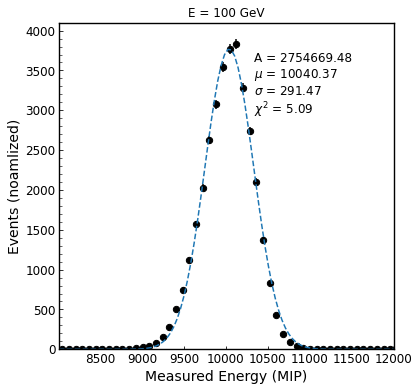

In [38]:
energy=100
E = arrays['mc'][energy]['rechit_energy']
earray = ak.sum(E, axis=1)
earray = earray[earray>0]

nsigma=3.0
plt.clf()
plt.figure(figsize=(6,6))
mean_ = np.mean(earray)
std_ = np.std(earray)

# plot data
data_range = (mean_-2e3, mean_+2e3)
M = np.linspace(data_range[0], data_range[1], 100)

data_hist2_array = plt.hist(earray,
         histtype='step', color='w', linewidth=0,
         range=data_range, bins=50)

xarray = (data_hist2_array[1][1:]+data_hist2_array[1][:-1])/2
yarray = data_hist2_array[0]

plt.scatter(xarray, yarray, marker='o', c='black', s=40)
plt.bar(xarray, yarray, width=0.05, color='none', yerr=np.sqrt(yarray))

results = curve_fit(GausPDF, xarray, yarray, 
                p0=(max(yarray), mean_, std_))
E = yarray-np.array([ GausPDF(m, *results[0]) for m in xarray])
E = E/(np.sqrt(yarray+0.001))
chi2 = np.sqrt(sum(E**2)/(len(E)-1))

plt.plot(M, [ GausPDF(m, *results[0]) for m in M], linestyle='dashed')

# plot data
plt.xlim(data_range)
plt.ylabel('Events (noamlized)', size=14)
plt.xlabel('Measured Energy (MIP)', size=14)
stat_text = '''
A = {:0.2f}
$\mu$ = {:0.2f}
$\sigma$ = {:0.2f}
$\chi^2$ = {:0.2f}
'''.format(results[0][0], results[0][1], abs(results[0][2]), chi2)
stat_text_box = plt.text(x=mean_+0.25*nsigma*std_, y=0.7*max(yarray),
    s=stat_text,
    fontsize=12,
    fontfamily='sans-serif',
    horizontalalignment='left', 
    verticalalignment='bottom')
plt.title('E = {} GeV'.format(energy))
plt.show()

In [39]:
layers_zpos = np.unique(np.array(ak.flatten(arrays['mc'][300]['rechit_z'])))
reweighted_energy = {'data': {}, 'mc': {}}

reweighted_energy['mc'][100] = ak.zeros_like(arrays['mc'][100]['rechit_energy'])
for il, l in enumerate(layers_zpos[0:28]):
    mask = arrays['mc'][100]['rechit_z']==l
    reweighted_energy['mc'][100] = arrays['mc'][100]['rechit_energy']*1e-3*casinfo['mean_dE'][il]*mask+reweighted_energy['mc'][100]

<Figure size 432x288 with 0 Axes>

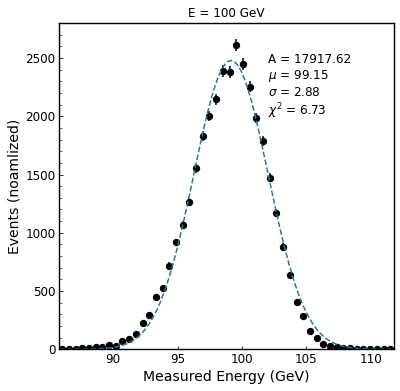

In [40]:
energy=100
earray = ak.sum(reweighted_energy['mc'][energy], axis=1)
earray = earray[earray>0]
nsigma=3.0
plt.clf()
plt.figure(figsize=(6,6))
mean_ = np.mean(earray)
std_ = np.std(earray)

# plot data
data_range = (mean_-nsigma*std_, mean_+nsigma*std_)
M = np.linspace(data_range[0], data_range[1], 100)

data_hist2_array = plt.hist(earray,
         histtype='step', color='w', linewidth=0,
         range=data_range, bins=50)

xarray = (data_hist2_array[1][1:]+data_hist2_array[1][:-1])/2
yarray = data_hist2_array[0]

plt.scatter(xarray, yarray, marker='o', c='black', s=40)
plt.bar(xarray, yarray, width=0.05, color='none', yerr=np.sqrt(yarray))

results = curve_fit(GausPDF, xarray, yarray, 
                p0=(max(yarray), mean_, std_),
                bounds=((0,0,0),(1e6,1e3,1e3)))
E = yarray-np.array([ GausPDF(m, *results[0]) for m in xarray])
E = E/(np.sqrt(yarray+0.001))
chi2 = np.sqrt(sum(E**2)/(len(E)-1))

plt.plot(M, [ GausPDF(m, *results[0]) for m in M], linestyle='dashed')

# plot data
plt.xlim(data_range)
plt.ylabel('Events (noamlized)', size=14)
plt.xlabel('Measured Energy (GeV)', size=14)
stat_text = '''
A = {:0.2f}
$\mu$ = {:0.2f}
$\sigma$ = {:0.2f}
$\chi^2$ = {:0.2f}
'''.format(results[0][0], results[0][1], results[0][2], chi2)
stat_text_box = plt.text(x=mean_+0.25*nsigma*std_, y=0.7*max(yarray),
    s=stat_text,
    fontsize=12,
    fontfamily='sans-serif',
    horizontalalignment='left', 
    verticalalignment='bottom')
plt.title('E = {} GeV'.format(energy))
plt.show()

<Figure size 432x288 with 0 Axes>

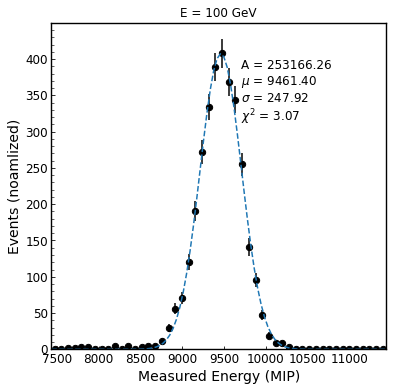

In [41]:
energy=100
earray = ak.sum(arrays['data'][energy]['rechit_energy'], axis=1)
earray = earray[earray>0]
nsigma=3.0
plt.clf()
plt.figure(figsize=(6,6))
mean_ = np.mean(earray)
std_ = np.std(earray)

# plot data
data_range = (mean_-2e3, mean_+2e3)
M = np.linspace(data_range[0], data_range[1], 100)

data_hist2_array = plt.hist(earray,
         histtype='step', color='w', linewidth=0,
         range=data_range, bins=50)

xarray = (data_hist2_array[1][1:]+data_hist2_array[1][:-1])/2
yarray = data_hist2_array[0]

plt.scatter(xarray, yarray, marker='o', c='black', s=40)
plt.bar(xarray, yarray, width=0.05, color='none', yerr=np.sqrt(yarray))

results = curve_fit(GausPDF, xarray, yarray, 
                p0=(max(yarray), mean_, std_))
E = yarray-np.array([ GausPDF(m, *results[0]) for m in xarray])
E = E/(np.sqrt(yarray+0.001))
chi2 = np.sqrt(sum(E**2)/(len(E)-1))

plt.plot(M, [ GausPDF(m, *results[0]) for m in M], linestyle='dashed')

# plot data
plt.xlim(data_range)
plt.ylabel('Events (noamlized)', size=14)
plt.xlabel('Measured Energy (MIP)', size=14)
stat_text = '''
A = {:0.2f}
$\mu$ = {:0.2f}
$\sigma$ = {:0.2f}
$\chi^2$ = {:0.2f}
'''.format(results[0][0], results[0][1], abs(results[0][2]), chi2)
stat_text_box = plt.text(x=mean_+0.25*nsigma*std_, y=0.7*max(yarray),
    s=stat_text,
    fontsize=12,
    fontfamily='sans-serif',
    horizontalalignment='left', 
    verticalalignment='bottom')
plt.title('E = {} GeV'.format(energy))
plt.show()

here
plotting energy = 20 GeV in 0, 0
here
plotting energy = 30 GeV in 0, 1
here
plotting energy = 50 GeV in 0, 2
here
plotting energy = 80 GeV in 0, 3
here
plotting energy = 100 GeV in 0, 4
here
plotting energy = 150 GeV in 1, 0
here
plotting energy = 200 GeV in 1, 1
here
plotting energy = 250 GeV in 1, 2
here
plotting energy = 300 GeV in 1, 3


<Figure size 432x288 with 0 Axes>

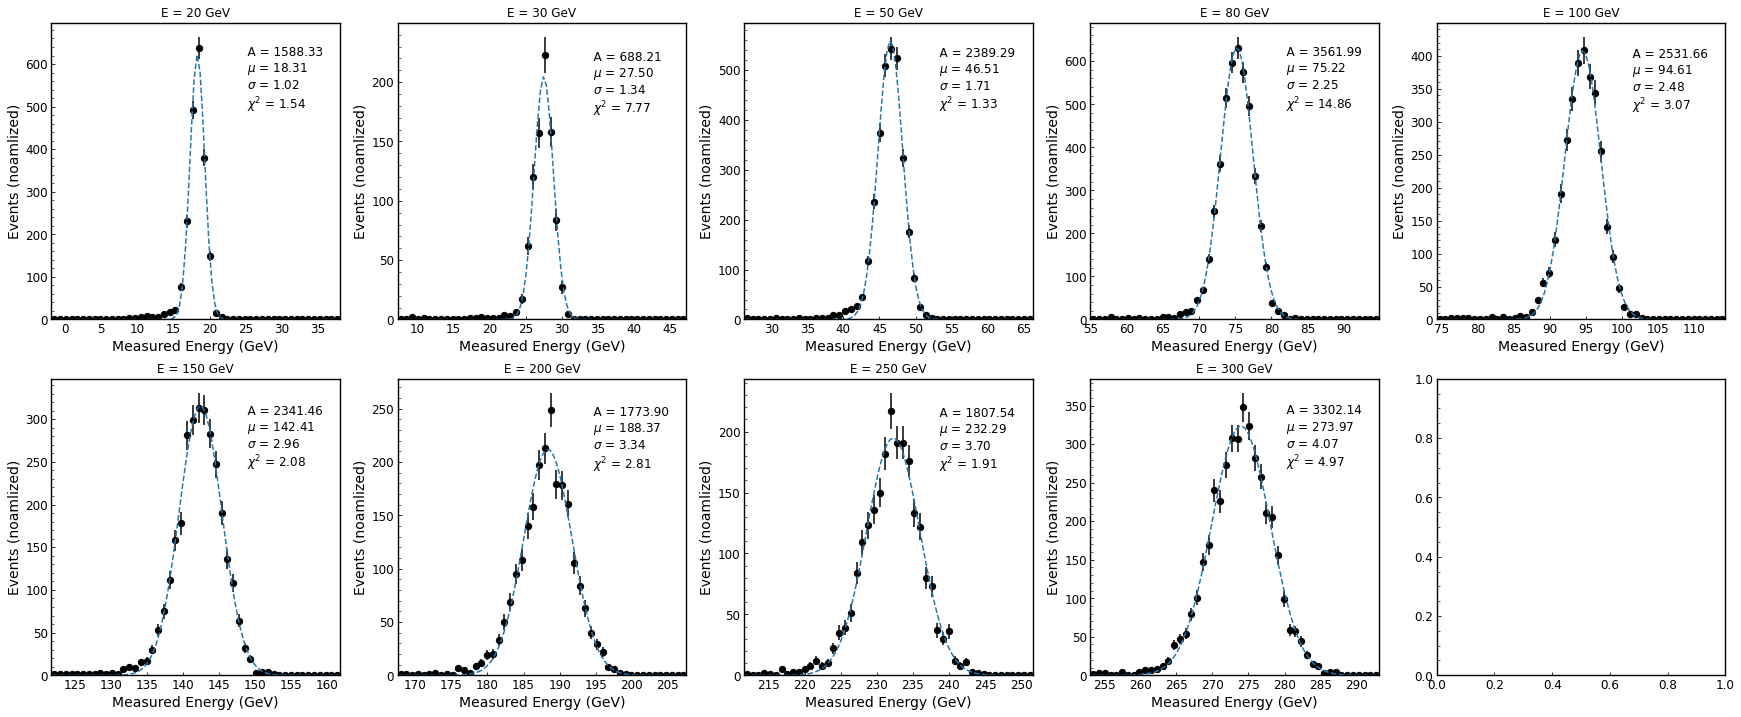

In [42]:
plt.clf()
fig, axarray = plt.subplots(2, 5)
fig.set_figheight(12)
fig.set_figwidth(30)

elist = list(arrays['data'].keys())
elist.sort()

for ie, e in enumerate(elist):
    irow = int(ie/5)
    jcol = int(ie%5)
    earray = ak.sum(arrays['data'][e]['rechit_energy'], axis=1)*0.01
    earray = earray[earray>0]
#     np.savetxt(f"/home/rusack/vadna042/{e}.csv", earray, delimiter=",")
#     print('here')
    fit_parameters['data'][e] = fit_gaussian(earray, axarray[irow, jcol], 'data', e)

plt.show()

plotting energy = 20 GeV in 0, 0
plotting energy = 30 GeV in 0, 1
plotting energy = 50 GeV in 0, 2
plotting energy = 80 GeV in 0, 3
plotting energy = 100 GeV in 0, 4
plotting energy = 120 GeV in 1, 0
plotting energy = 150 GeV in 1, 1
plotting energy = 200 GeV in 1, 2
plotting energy = 250 GeV in 1, 3
plotting energy = 300 GeV in 1, 4


<Figure size 432x288 with 0 Axes>

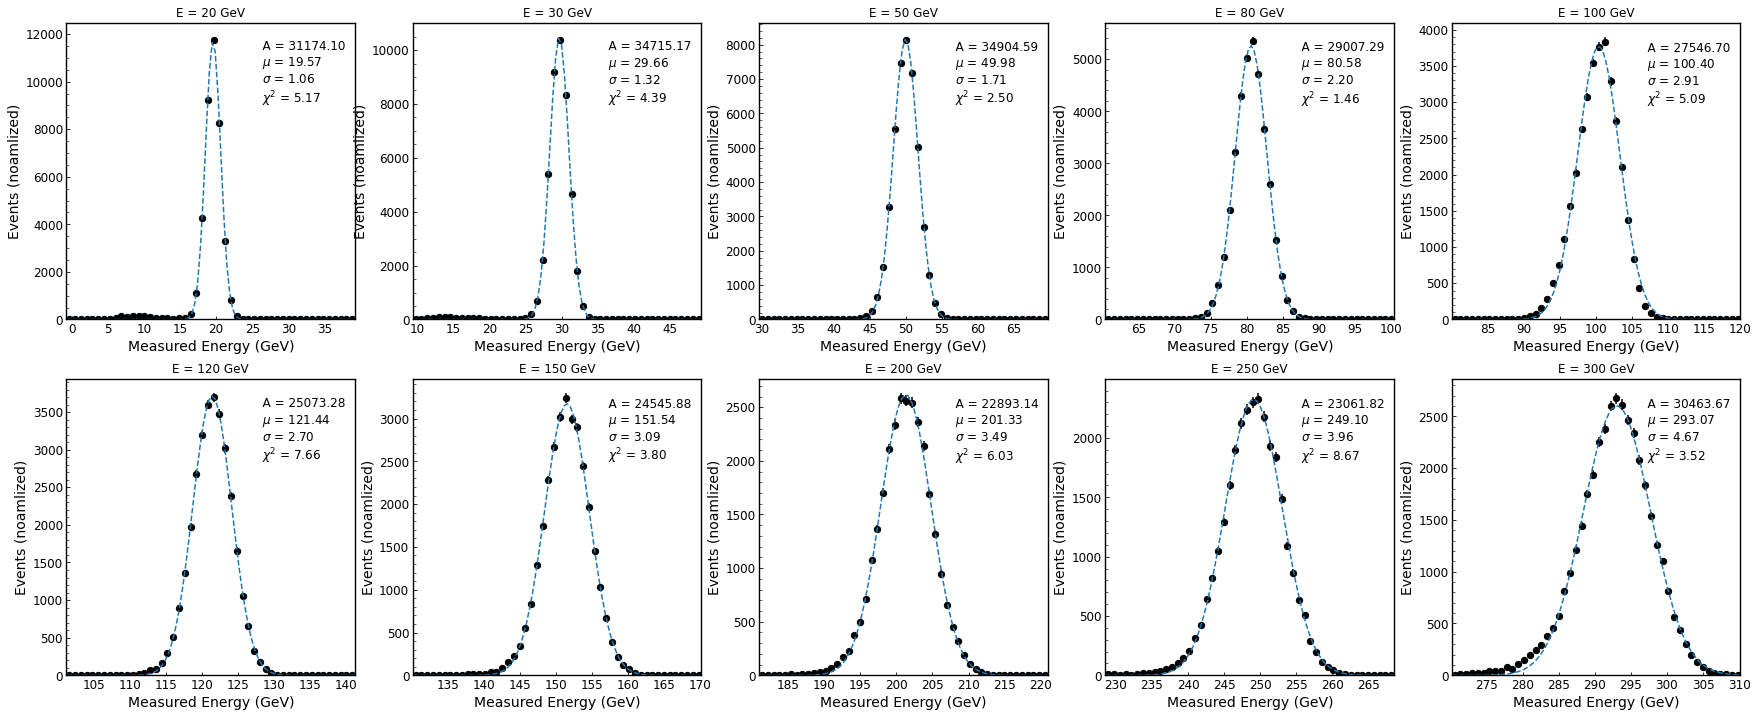

In [50]:
plt.clf()
fig, axarray = plt.subplots(2, 5)
fig.set_figheight(12)
fig.set_figwidth(30)

elist = list(arrays['mc'].keys())
elist.sort()

for ie, e in enumerate(elist):
    irow = int(ie/5)
    jcol = int(ie%5)
    earray = ak.sum(arrays['mc'][e]['rechit_energy'], axis=1)*0.01
    earray = earray[earray>0]
    
    fit_parameters['mc'][e] = fit_gaussian(earray, axarray[irow, jcol], 'mc', e)

plt.show()

Fit gaussian to MIP distributions

plotting energy = 20 GeV in 0, 0
plotting energy = 30 GeV in 0, 1
plotting energy = 50 GeV in 0, 2
plotting energy = 80 GeV in 0, 3
plotting energy = 100 GeV in 0, 4
plotting energy = 120 GeV in 1, 0
plotting energy = 150 GeV in 1, 1
plotting energy = 200 GeV in 1, 2
plotting energy = 250 GeV in 1, 3
plotting energy = 300 GeV in 1, 4


<Figure size 432x288 with 0 Axes>

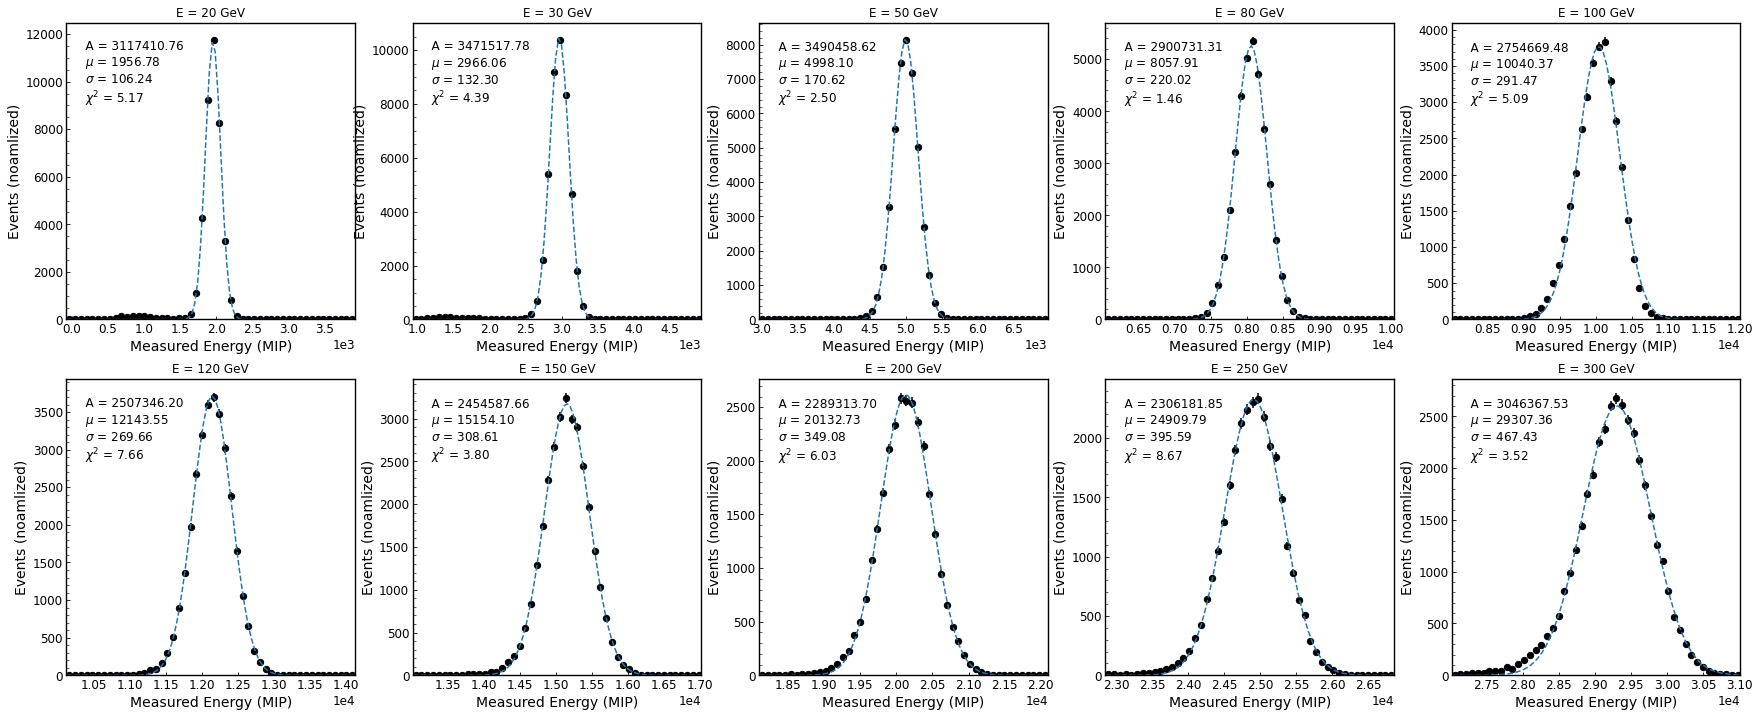

In [51]:
fit_parameters_mip = {'data': {}, 'mc': {}}

plt.clf()
fig, axarray = plt.subplots(2, 5)
fig.set_figheight(12)
fig.set_figwidth(30)

elist = list(arrays['mc'].keys())
elist.sort()

for ie, e in enumerate(elist):
    irow = int(ie/5)
    jcol = int(ie%5)
    earray = ak.sum(arrays['mc'][e]['rechit_energy'], axis=1)
    earray = earray[earray>0]
    fit_parameters_mip['mc'][e] = fit_gaussian_mip(earray, axarray[irow, jcol], 'mc', e)

plt.show()

plotting energy = 20 GeV in 0, 0
plotting energy = 30 GeV in 0, 1
plotting energy = 50 GeV in 0, 2
plotting energy = 80 GeV in 0, 3
plotting energy = 100 GeV in 0, 4
plotting energy = 150 GeV in 1, 0
plotting energy = 200 GeV in 1, 1
plotting energy = 250 GeV in 1, 2
plotting energy = 300 GeV in 1, 3


<Figure size 432x288 with 0 Axes>

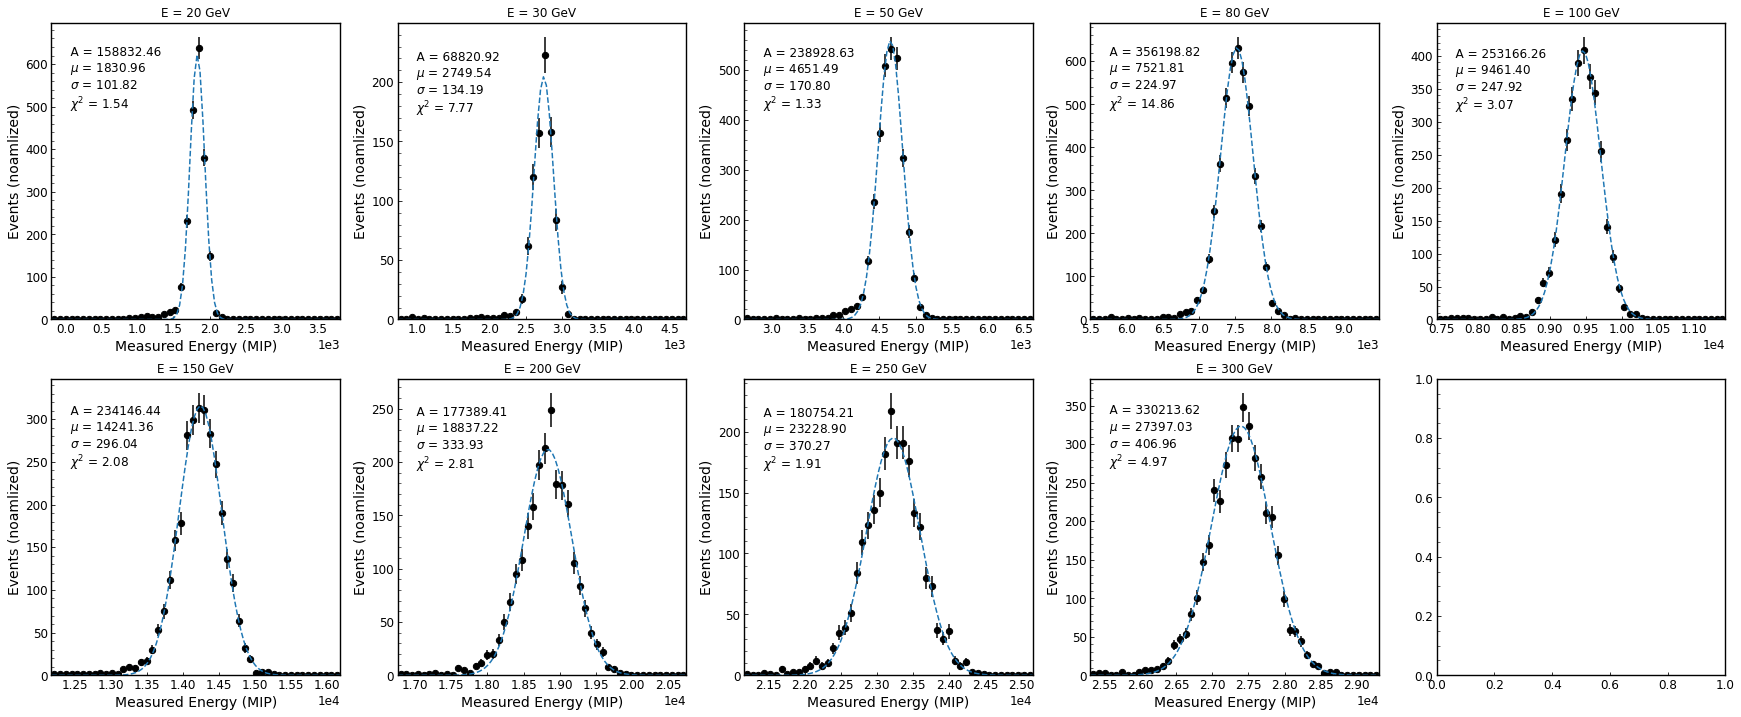

In [52]:
plt.clf()
fig, axarray = plt.subplots(2, 5)
fig.set_figheight(12)
fig.set_figwidth(30)

elist = list(arrays['data'].keys())
elist.sort()

for ie, e in enumerate(elist):
    irow = int(ie/5)
    jcol = int(ie%5)
    earray = ak.sum(arrays['data'][e]['rechit_energy'], axis=1)
    earray = earray[earray>0]
    fit_parameters_mip['data'][e] = fit_gaussian_mip(earray, axarray[irow, jcol], 'data', e)

plt.show()